In [2]:
import pandas as pd
import numpy as np
import itertools
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from IPython.display import display

from scipy.stats import randint

import seaborn as sns

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [3]:
df_original = pd.read_csv('data_ml_test.csv',index_col=[0])
df = df_original.copy()

### Vizualize

In [4]:
df.columns

Index(['date', 'arrondissement', 'offer link', 'title', 'price',
       'localization', 'description', 'more', 'caracteristiques', 'X', 'Y',
       'type_link', 'type_title', 'surface', 'pieces', 'chambre', 'bains',
       'age', 'etage', 'Etat', 'TV', 'Marbre', 'Antenne parabolique',
       'Carrelage', 'Terrasse', 'Concierge', 'Four', 'Climatisation',
       'Vue sur les montagnes', 'Réfrigérateur', 'Chauffage central',
       'Salon Marocain', 'Cheminée', 'Salon européen', 'Garage', 'Micro-ondes',
       'Double vitrage', 'Jardin', 'Internet', 'Chambre rangement',
       'Ascenseur', 'Machine à laver', 'Piscine', 'Sécurité', 'Porte blindée',
       'Vue sur mer', 'Cuisine équipée', 'Parquet', 'prix/m²'],
      dtype='object')

In [5]:
df["Etat"].value_counts()

Bon état     5476
Nouveau      1674
À rénover     439
Name: Etat, dtype: int64

In [6]:
df.age.value_counts()

10-20 ans          1848
5-10 ans           1672
1-5 ans             871
Moins d'un an       513
20-30 ans           490
30-50 ans           151
50-70 ans            35
70-100 ans            5
Plus de 100 ans       1
Name: age, dtype: int64

In [336]:
df.arrondissement.value_counts()

Maârif           1748
Anfa             1561
Hay-Hassani      1297
Aïn-Chock        1122
Sidi-Belyout      507
Roches-Noires     396
Aïn-Sebaâ         363
Sidi-Moumen       330
Bernoussi         283
Mers-Sultan       249
Moulay-Rachid     117
Hay-Mohammadi      89
Al-Fida            84
Ben-M'sick         66
Sidi-Othmane       66
Sbata              50
Name: arrondissement, dtype: int64

In [337]:
df['type'] = df[df['type_link']==df['type_title']]['type_link']

In [338]:
df['type'].value_counts()

A         5922
V         1157
Jesspa     413
M          405
S          249
D          116
I           40
R            2
Name: type, dtype: int64

In [339]:
df.price.isnull().sum()

1160

## Data prep

### Filter 

In [340]:
df = df[df['type']=='A']
df = df[df.price.notnull()]
df = df[df['prix/m²']>4000]
df = df[df['prix/m²']<27000]
df = df[df['bains']<=4]
df = df.drop(['date',  'offer link', 'title', 'arrondissement', 'prix/m²', ''
       'localization', 'description', 'more', 'caracteristiques', 'type_title', 'type_link', 'type'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 2 to 8325
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  4765 non-null   float64
 1   X                      4765 non-null   float64
 2   Y                      4765 non-null   float64
 3   surface                4765 non-null   float64
 4   pieces                 4744 non-null   float64
 5   chambre                4765 non-null   float64
 6   bains                  4765 non-null   float64
 7   age                    3388 non-null   object 
 8   etage                  3723 non-null   float64
 9   Etat                   4525 non-null   object 
 10  TV                     612 non-null    float64
 11  Marbre                 1752 non-null   float64
 12  Antenne parabolique    1846 non-null   float64
 13  Carrelage              965 non-null    float64
 14  Terrasse               2246 non-null   float64
 15  Conc

In [341]:
# age
df.age = df.age.fillna("")
age_keys = list(df.age.value_counts().keys())
# change 40, 60 ,85 to 25 (match avito data)
age_values = [29.5, 15.0, 7.5, 3, 0.5, 25, 40, 60, 85]
age_dict = {k:v for k,v in zip(age_keys, age_values)}
def parse_age(v):
    return age_dict[v]
df.age = df.age.apply(parse_age)
df.age.value_counts()

29.5    1377
15.0    1194
7.5     1095
3.0      548
0.5      268
25.0     228
40.0      47
60.0       7
85.0       1
Name: age, dtype: int64

In [342]:
# etage
# 1, 2, 3 and 4 are the most represented equally. the median would be a good choice to fill na values
# df.etage.value_counts()
df.etage = df.etage.fillna(df.etage.median())

In [343]:
# etat
df = df.dropna(subset=['Etat', 'pieces'])

In [344]:
# dtype
df.pieces = df.pieces.astype(int)
df.chambre = df.chambre.astype(int)
df.bains = df.bains.astype(int)
df.etage = df.etage.astype(int)

In [345]:
# categorical vars
cat_col = df.columns[10:]
df.fillna({k:0 for k in cat_col}, inplace=True)

In [346]:
df.Etat.value_counts()

Bon état     3467
Nouveau       933
À rénover     116
Name: Etat, dtype: int64

In [347]:
def parse_etat(v):
    d = {"Bon état": 0, "Nouveau": 1, "À rénover": 2}
    return d[str(v)]
df['Etat_2'] = df.Etat.apply(parse_etat)

In [348]:
Etat_dummies = pd.get_dummies(df['Etat'])
df = pd.concat([df, Etat_dummies], axis=1).drop(['Etat'], axis=1)

In [349]:
df = df.astype({k:int for k in cat_col})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4516 entries, 2 to 8325
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  4516 non-null   float64
 1   X                      4516 non-null   float64
 2   Y                      4516 non-null   float64
 3   surface                4516 non-null   float64
 4   pieces                 4516 non-null   int32  
 5   chambre                4516 non-null   int32  
 6   bains                  4516 non-null   int32  
 7   age                    4516 non-null   float64
 8   etage                  4516 non-null   int32  
 9   TV                     4516 non-null   int32  
 10  Marbre                 4516 non-null   int32  
 11  Antenne parabolique    4516 non-null   int32  
 12  Carrelage              4516 non-null   int32  
 13  Terrasse               4516 non-null   int32  
 14  Concierge              4516 non-null   int32  
 15  Four

In [350]:
# normalization
df_2 = df.copy()
df_2.X = (df_2.X-df_2.X.min())/(df_2.X.max()-df_2.X.min())

In [351]:
df_2.Y = (df_2.Y-df_2.Y.min())/(df_2.Y.max()-df_2.Y.min())

### Dim reduction with RF

In [352]:
all_columns = df_2.columns
features = df_2[all_columns[1:]]
target = df_2[['price']]

In [353]:
rfc = RandomForestClassifier()
rfc.fit(features,target)
importances = rfc.feature_importances_

C:\Users\yassine\AppData\Local\Temp/ipykernel_1128/1334013579.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(features,target)


In [354]:
d = {'features':features.columns, 'importance': importances}
df_importance = pd.DataFrame(d)
df_importance.set_index('features', inplace=True)
df_importance=df_importance.sort_values(by=['importance'], ascending=[False])
df_importance

,importance
features,
surface,0.127729
Y,0.096756
X,0.094045
etage,0.069947
age,0.056830
pieces,0.054723
chambre,0.028477
Terrasse,0.026832
Salon Marocain,0.024347


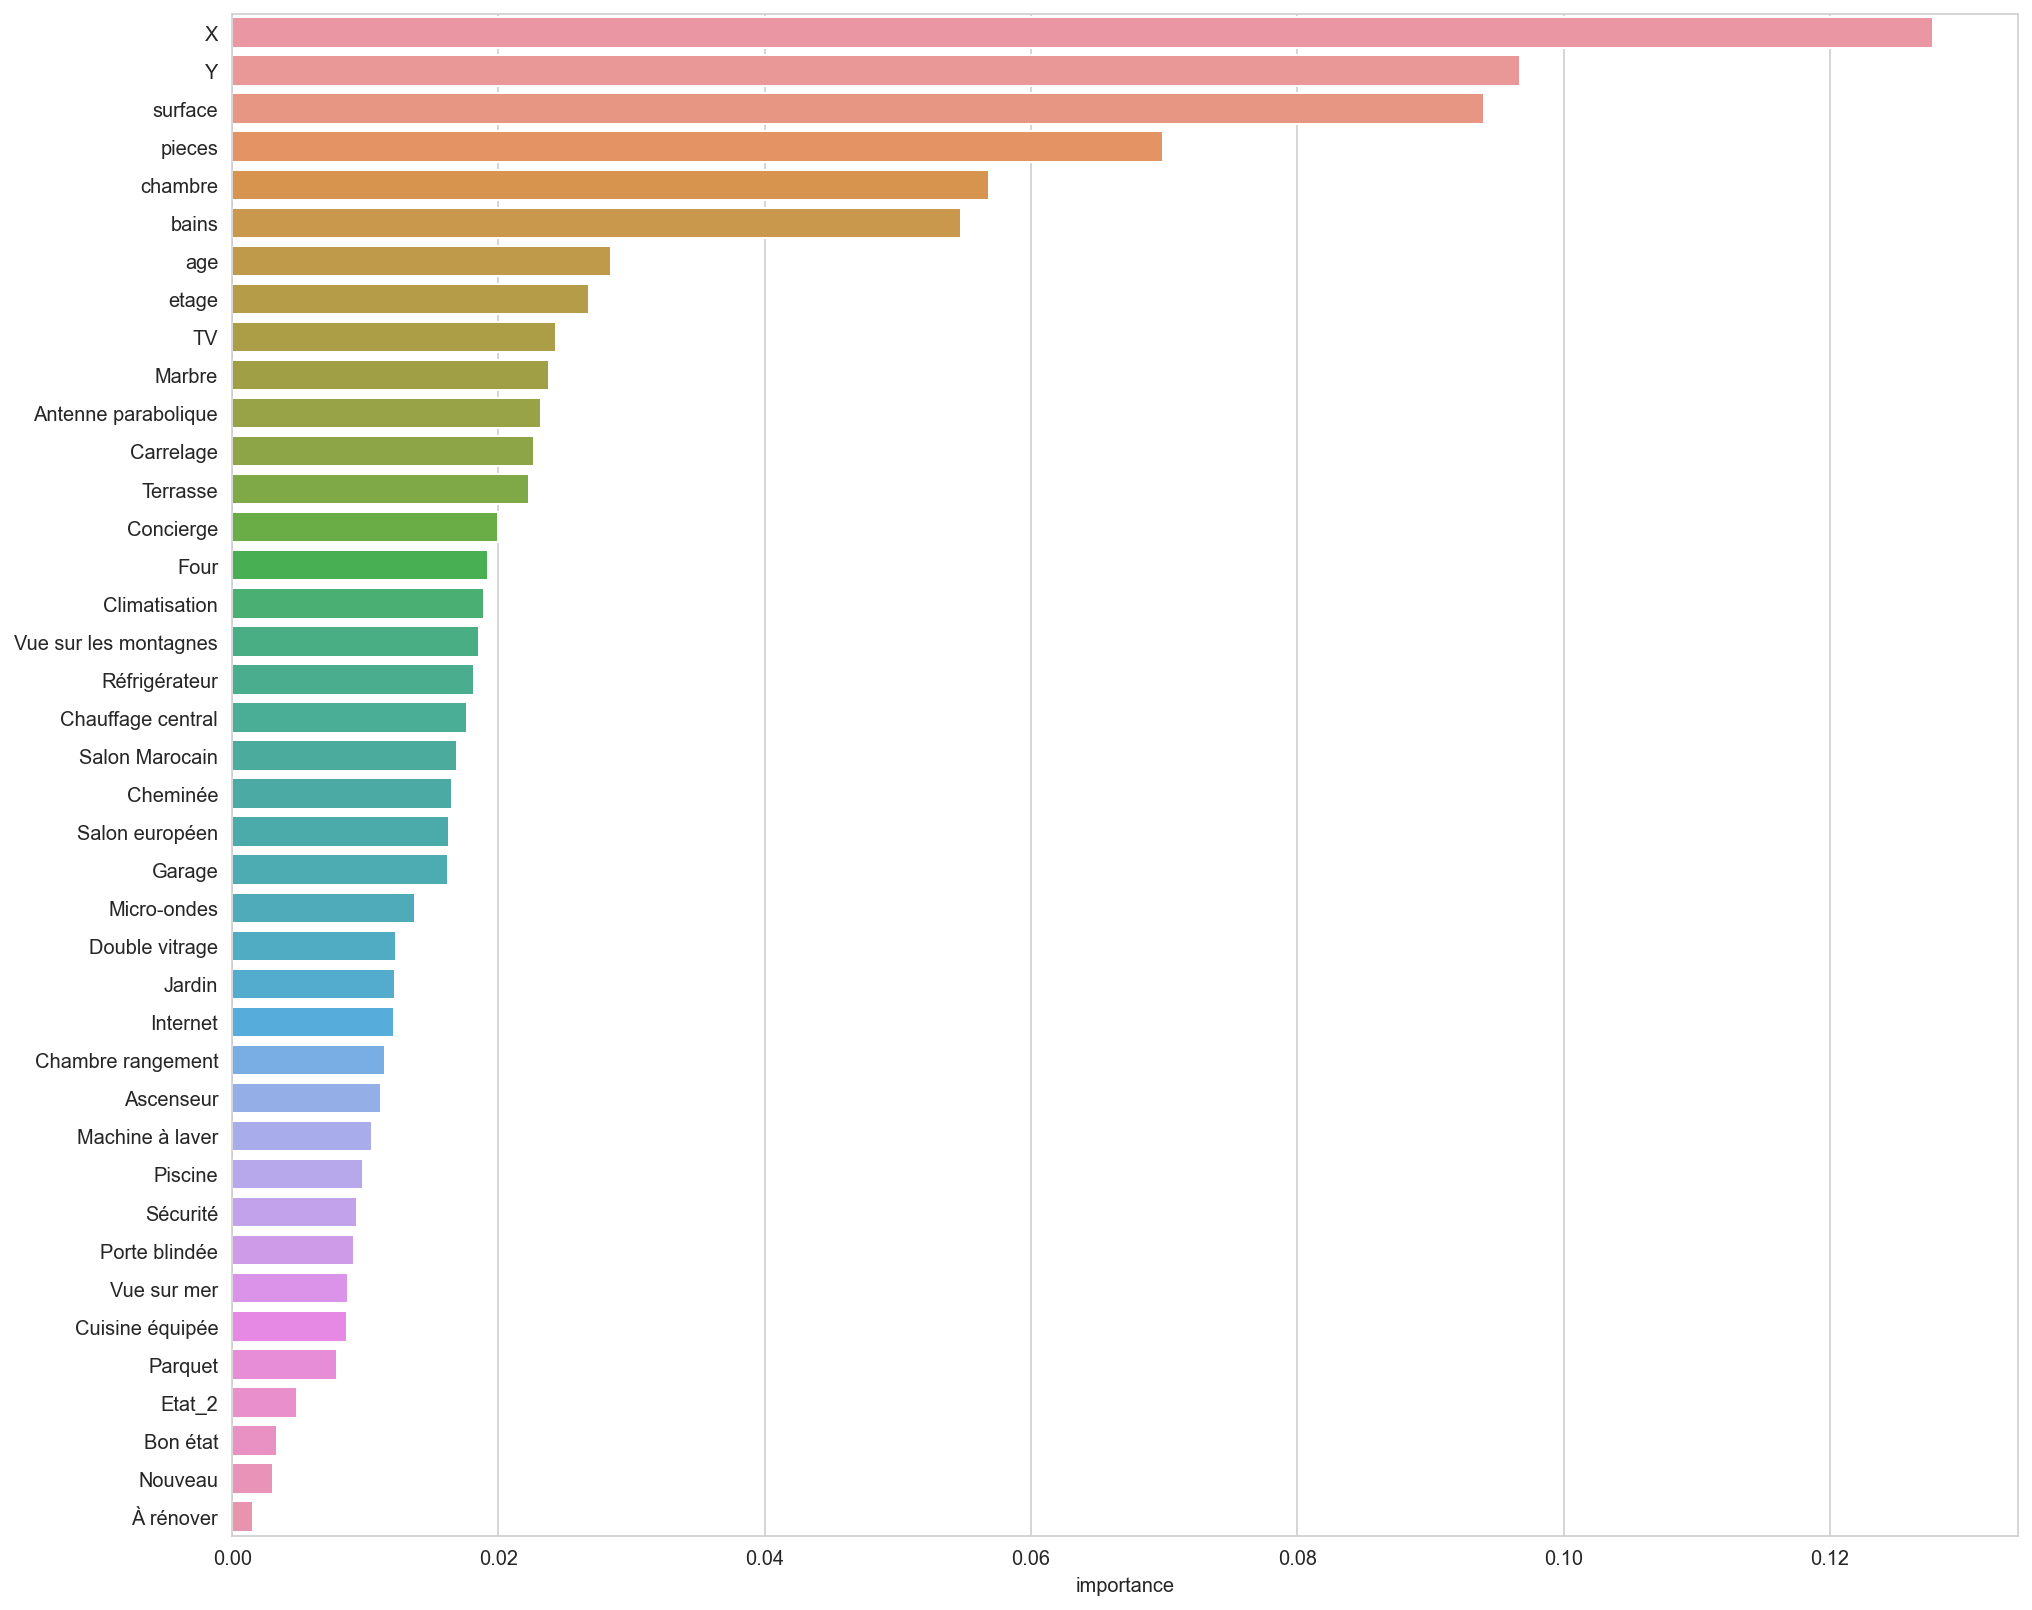

In [355]:
f, ax = plt.subplots(figsize=(16, 14))
ax = sns.barplot(x='importance',y=features.columns, data=df_importance)

### Dim reduction with PCA for price, chambre, pieces

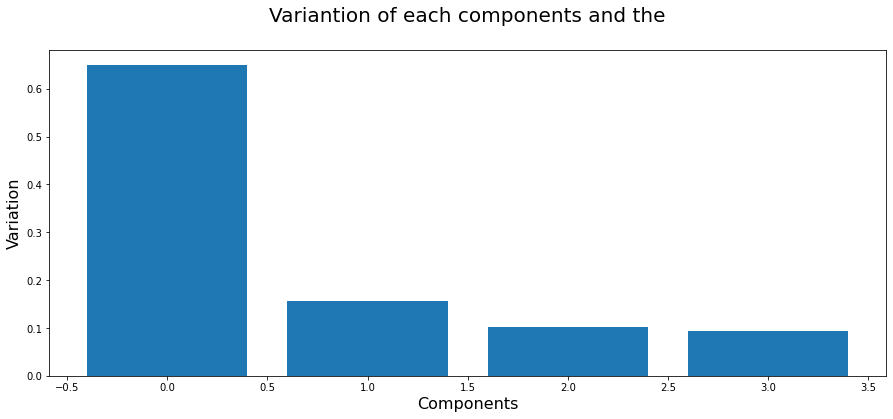

[0.6492083  0.15587288 0.10209478 0.09282403]


In [288]:
X_pca = df_2[["surface", "chambre", "pieces", "bains"]]
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

#Calculate the PCAs
pca = PCA()
pca.fit(X_pca_scaled)
variation = pca.explained_variance_ratio_

ax = plt.gca()
ax.set_ylabel('Variation', fontsize=16)
ax.set_xlabel('Components', fontsize=16)
ax.set_title('Variantion of each components and the\n', fontsize=20)

plt.bar(range(len(variation)), variation)
plt.show()
print(variation)

In [289]:
X_to_PCA = pca.fit_transform(X_pca_scaled)

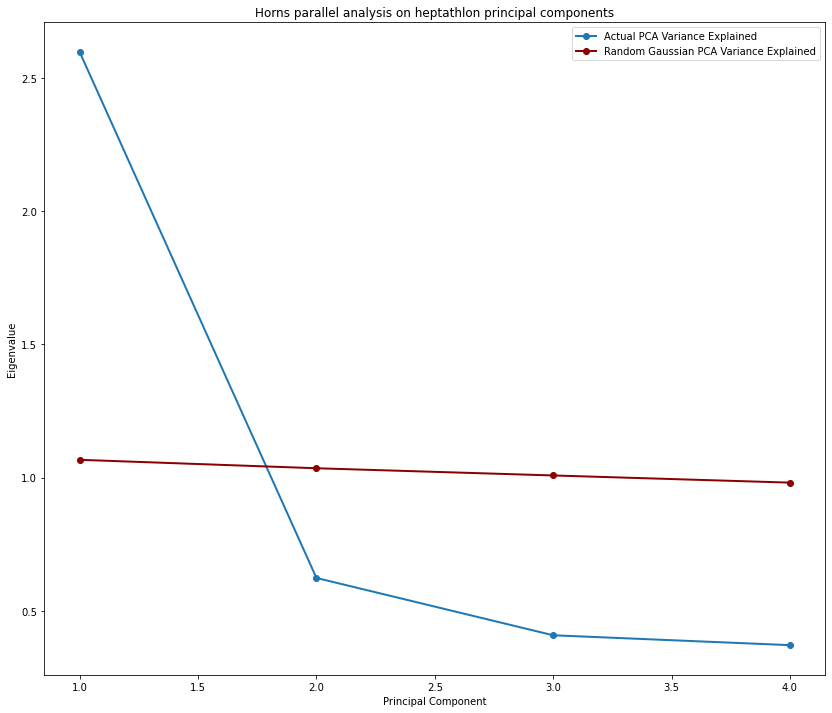

In [290]:
def horn_parallel_analysis(shape, iters=1000, percentile=95):
    pca = PCA(n_components=shape[1])
    eigenvals = []
    
    for i in range(iters):
        rdata = np.random.normal(0,1,size=shape)
        pca.fit(rdata)
        eigenvals.append(pca.explained_variance_)
    
    eigenvals = np.array(eigenvals)
    return np.percentile(eigenvals, percentile, axis=0)

hep_pa = horn_parallel_analysis(X_to_PCA.shape, percentile=95)

fig, ax = plt.subplots(figsize=(14,12))

ax.plot(range(1, X_to_PCA.shape[1]+1), pca.explained_variance_, lw=2, marker='o')
ax.plot(range(1, X_to_PCA.shape[1]+1), hep_pa, lw=2, color='darkred', marker='o')
ax.set_title("Horns parallel analysis on heptathlon principal components")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Eigenvalue")

plt.legend(['Actual PCA Variance Explained', "Random Gaussian PCA Variance Explained"])
plt.show()

In [299]:
pca = PCA(n_components=1)
pca.fit(X_pca_scaled)

PCA(n_components=1)

In [300]:
Dict = {}
for i in range(len(pca.components_)):
    Dict['PC'+str(i)]= pca.components_[i]
    
df_components = pd.DataFrame(Dict,index=X_pca.columns)
df_components.head()

,PC0
surface,0.517819
chambre,0.520786
pieces,0.473677
bains,0.486083


In [301]:
for column in df_components.columns:
    print (column, df_components[column].argmax(), df_components[column].max())

PC0 1 0.5207857519170462


### Pred

In [426]:
X = features[features.columns]
y = target
X

,X,Y,surface,pieces,chambre,bains,age,etage,TV,Marbre,...,Piscine,Sécurité,Porte blindée,Vue sur mer,Cuisine équipée,Parquet,Etat_2,Bon état,Nouveau,À rénover
2,0.895114,0.167946,87.0,3,2,2,29.5,3,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.892967,0.166851,78.0,3,2,1,29.5,3,0,0,...,0,1,1,0,0,0,0,1,0,0
7,0.895353,0.167937,92.0,3,2,2,3.0,4,0,1,...,0,1,0,0,1,0,0,1,0,0
9,0.895364,0.167950,93.0,2,2,2,3.0,8,0,1,...,0,1,0,0,1,0,0,1,0,0
10,0.895114,0.167946,68.0,3,2,2,15.0,5,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,0.894708,0.168415,38.0,3,2,1,3.0,3,0,0,...,0,1,0,0,0,0,1,0,1,0
8322,0.895291,0.169110,88.0,6,2,2,7.5,2,1,1,...,0,1,1,0,1,0,0,1,0,0
8323,0.895745,0.167938,61.0,3,2,1,3.0,3,0,0,...,0,1,1,0,1,0,1,0,1,0
8324,0.895256,0.168545,80.0,6,3,1,29.5,3,0,0,...,0,0,0,0,0,0,0,1,0,0


In [427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [428]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [429]:
pip install xgboost


^C
Note: you may need to restart the kernel to use updated packages.


In [430]:
len(y_train)

3025

In [431]:
y_pred = xgb_model.predict(X_test)

<AxesSubplot:xlabel='price'>

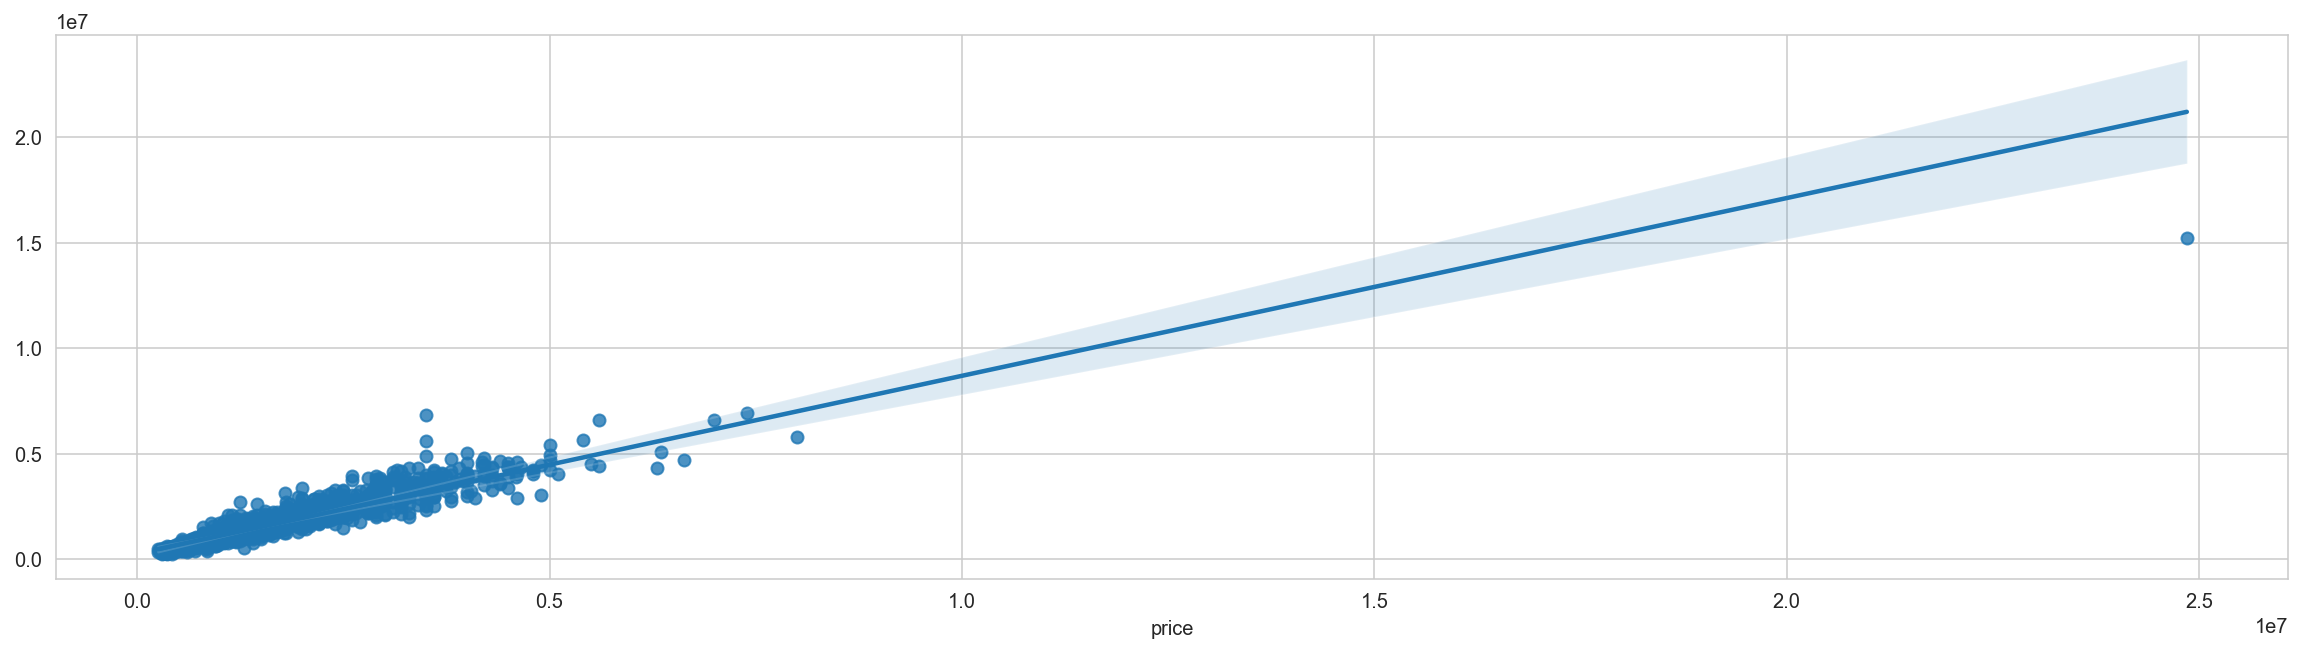

In [432]:
#We can also plot the samples in seaborn
f, ax = plt.subplots(figsize=(20, 5))
sns.regplot(x=y_test, y=y_pred)

In [434]:
#RMSE of the random forrest model using cross validation 
scores_xgb = cross_val_score(xgb_model, X_test, y_test,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores_xgb = np.sqrt(-scores_xgb)
print(rmse_scores_xgb)

[ 326413.57552366  402414.04830644  366685.67309113  410719.45903969
  381305.6540318   362364.48565123 1591760.94468236  422190.22905366
  430055.36716389  344224.13799352]


In [435]:
print(rmse_scores_xgb.mean())

503813.35745373816


In [436]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.8744473276564807

In [437]:
#### RF

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

scores_rf = cross_val_score(rf, X_test, y_test,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores_rf = np.sqrt(-scores_rf)
print(rmse_scores_rf.mean())

C:\Users\yassine\AppData\Local\Temp/ipykernel_1128/1521292255.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\yassine\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yassine\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yassine\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expec

493546.0274202743


In [438]:
r2_score(y_test, rf.predict(X_test))

0.8521048519129406

In [439]:
X_test.columns

Index(['X', 'Y', 'surface', 'pieces', 'chambre', 'bains', 'age', 'etage', 'TV',
       'Marbre', 'Antenne parabolique', 'Carrelage', 'Terrasse', 'Concierge',
       'Four', 'Climatisation', 'Vue sur les montagnes', 'Réfrigérateur',
       'Chauffage central', 'Salon Marocain', 'Cheminée', 'Salon européen',
       'Garage', 'Micro-ondes', 'Double vitrage', 'Jardin', 'Internet',
       'Chambre rangement', 'Ascenseur', 'Machine à laver', 'Piscine',
       'Sécurité', 'Porte blindée', 'Vue sur mer', 'Cuisine équipée',
       'Parquet', 'Etat_2', 'Bon état', 'Nouveau', 'À rénover'],
      dtype='object')

In [459]:
lat_jeb = 33.6243
lat_jeb_new = (lat_jeb-df_original.X.min())/(df_original.X.max()-df_original.X.min())
print(lat_jeb_new)
lon_jeb = -7.139
lon_jeb_new = (lon_jeb-df_original.Y.min())/(df_original.Y.max()-df_original.Y.min())
print(lon_jeb_new)
# df_2.X = (df_2.X-df_2.X.min())/(df_2.X.max()-df_2.X.min())
X_jeb = [lat_jeb_new, lon_jeb_new, 48, 3, 4, 1, 19, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

len(X_jeb)


0.8218927112212797
0.17570840528588005


40

In [460]:
xgb_model.predict(np.array(X_jeb).reshape(1, -1))

array([241817.66], dtype=float32)

In [479]:
lat_b = 33.5956
lat_b_new = (lat_b-df_original.X.min())/(df_original.X.max()-df_original.X.min())
print(lat_b_new)
lon_b = -7.6319
lon_b_new = (lon_b-df_original.Y.min())/(df_original.Y.max()-df_original.Y.min())
print(lon_b_new)
# df_2.X = (df_2.X-df_2.X.min())/(df_2.X.max()-df_2.X.min())
X_b = [lat_b_new, lon_b_new, 200, 7, 6, 2, 24, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

len(X_b)

0.8214471057948014
0.1673272232618859


40

In [480]:
xgb_model.predict(np.array(X_b).reshape(1, -1))

array([512450.8], dtype=float32)